<a href="https://colab.research.google.com/github/habudayyeh/PINN-Helmholtz/blob/main/PINN_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Helmholtz Equation PINN Solver
Solve Helmholtz Equation using PINN Based on the solution provided by:

https://www.vincentsitzmann.com/siren/

https://github.com/vsitzmann/siren

https://arxiv.org/abs/2006.09661

My specific implementation can be found at:

https://github.com/habudayyeh/PINN-Helmholtz


### Change directory to repo directory:



In [1]:
import os
os.chdir('/content/PINN-Helmholtz')
print(os.getcwd())

/content/PINN-Helmholtz


###Imports

In [ ]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np

import utils, modules, training

#Training

###Parameters

In [ ]:
#Physical Parameters
side_length = 100.
source_coords = np.array([250., 202.])
wavelength = 0.3


#Training Parameters
logging_root= './logs'
experiment_name='wl'+str(wavelength)
batch_size = 32
lr = 5e-6
num_epochs = 10000
epochs_til_ckpt = 1000
steps_til_summary = 100
activation = 'sine'
mode = 'mlp'
velocity = 'uniform'
clip_grad = 0.0
use_lbfgs = False
checkpoint_path = None

###Datasets and dataloaders

In [ ]:
source_coords = 2*(source_coords/600 - 0.5) # Normalize source coords to between -1, 1

train_dataset = utils.SingleHelmholtzSource(
    sidelength=int(side_length),
    velocity=velocity,
    source_coords=source_coords,
    wavelength = wavelength,
    )

val_dataset =utils.SingleHelmholtzSource(
    sidelength=int(side_length/np.pi),
    velocity=velocity,
    source_coords=source_coords,
    wavelength = wavelength,
    )

train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              batch_size=batch_size,
                              num_workers=0
                              )
val_dataloader = DataLoader(val_dataset,
                            shuffle=True,
                            batch_size=batch_size,
                            num_workers=0
                            )

###Define Model and Loss

In [ ]:
# Define the model.
model = modules.SingleBVPNet(out_features=2,
                             type=activation,
                             mode=mode,
                             final_layer_factor=1.
                             )

model.cuda()

# Define the loss
loss_fn = utils.helmholtz_pml
summary_fn = utils.write_helmholtz_summary

root_path = os.path.join(logging_root, experiment_name)

###Train Model

In [8]:
training.train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=num_epochs,
    lr=lr,
    steps_til_summary=steps_til_summary,
    epochs_til_checkpoint=epochs_til_ckpt,
    model_dir=root_path,
    loss_fn=loss_fn,
    summary_fn=summary_fn,
    clip_grad=clip_grad,
    use_lbfgs=use_lbfgs
    )

SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0, Total loss 808411.000000, iteration time 0.150043
Running validation set...
Epoch 100, Total loss 237863.921875, iteration time 0.157777
Running validation set...
Epoch 200, Total loss 117106.171875, iteration time 0.162511
Running validation set...
Epoch 300, Total loss 56980.875000, iteration time 0.154862
Running validation set...
Epoch 400, Total loss 50633.023438, iteration time 0.153231
Running validation set...
Epoch 500, Total loss 42683.113281, iteration time 0.154584
Running validation set...
Epoch 600, Total loss 40822.082031, iteration time 0.152909
Running validation set...
Epoch 700, Total loss 45581.226562, iteration time 0.155451
Running validation set...
Epoch 800, Total loss 35061.109375, iteration time 0.155186
Running validation set...
Epoch 900, Total loss 34513.273438, iteration time 0.159794
Running validation set...
Epoch 1000, Total loss 33855.371094, iteration time 0.117693
Running validation set...
Epoch 1100, Total loss 39538.671875, iteration time 

KeyboardInterrupt: 

###Display Results

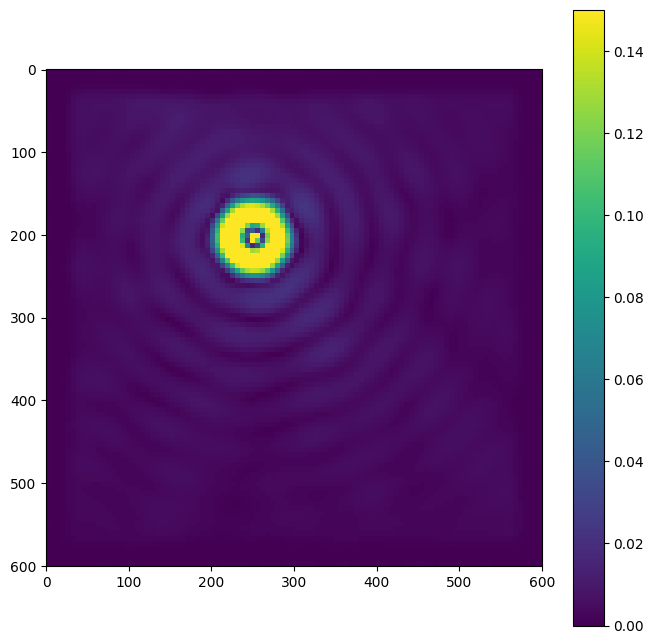

In [9]:
out_length = 600
with torch.no_grad():
    coords = utils.get_mgrid(int(side_length))
    model_out = model({'coords':coords.cuda()})

    fig, ax = plt.subplots(figsize=(8,8))
    E2 = model_out['model_out'][:,0]**2 + model_out['model_out'][:,1]**2
    absE = torch.sqrt(E2)
    im = ax.imshow(absE.cpu().view(int(side_length),int(side_length)).numpy().T,
                   extent=out_length*np.array([0,1,1,0]))
    im.set_clim([0,0.15])
    fig.colorbar(im, orientation='vertical')
    plt.show()

###Save Model

In [10]:
torch.save(model,'model_wl'+str(wavelength)+'.h5')

#Load Pretrained Model and Plot

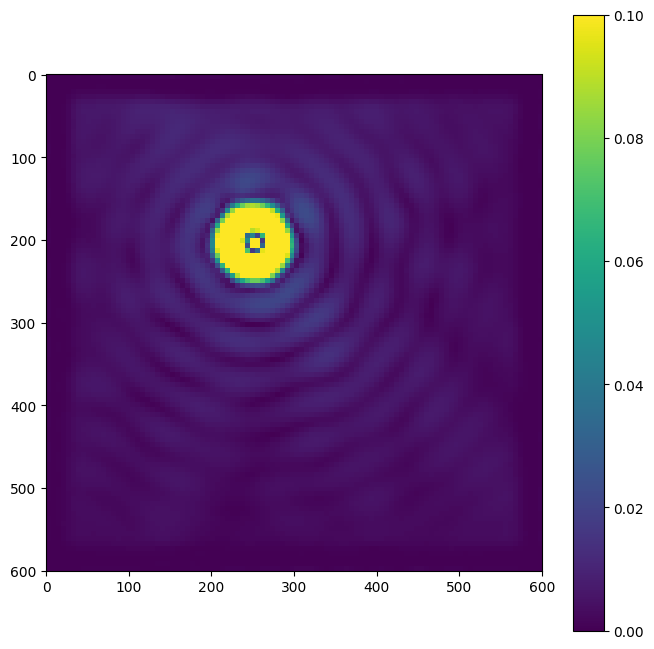

In [12]:
model1 = torch.load('model_wl0.3.h5',weights_only=False)
out_length = 600
with torch.no_grad():
    coords = utils.get_mgrid(int(side_length))
    model_out = model1({'coords':coords.cuda()})

    fig, ax = plt.subplots(figsize=(8,8))
    E2 = model_out['model_out'][:,0]**2 + model_out['model_out'][:,1]**2
    absE = torch.sqrt(E2)
    im = ax.imshow(absE.cpu().view(int(side_length),int(side_length)).numpy().T,
                   extent=out_length*np.array([0,1,1,0]))
    im.set_clim([0,0.1])
    fig.colorbar(im, orientation='vertical')
    plt.show()

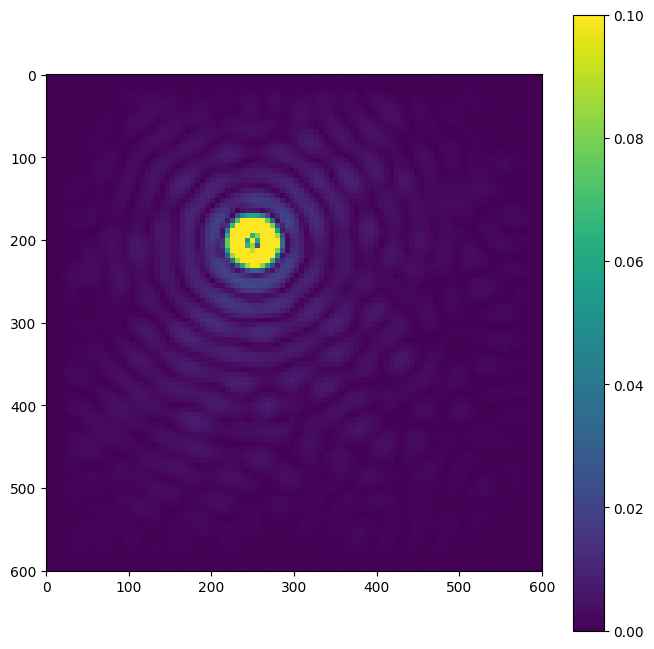

In [13]:
model1 = torch.load('model_wl0.2.h5',weights_only=False)
out_length = 600
with torch.no_grad():
    coords = utils.get_mgrid(int(side_length))
    model_out = model1({'coords':coords.cuda()})

    fig, ax = plt.subplots(figsize=(8,8))
    E2 = model_out['model_out'][:,0]**2 + model_out['model_out'][:,1]**2
    absE = torch.sqrt(E2)
    im = ax.imshow(absE.cpu().view(int(side_length),int(side_length)).numpy().T,
                   extent=out_length*np.array([0,1,1,0]))
    im.set_clim([0,0.1])
    fig.colorbar(im, orientation='vertical')
    plt.show()

# Install Necessary Packages
##Clone repository

In [ ]:
!git clone https://github.com/habudayyeh/PINN-Helmholtz.git

Cloning into 'PINN-Helmholtz'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 45 (delta 17), reused 22 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 22.40 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (17/17), done.


## Change directory and install necessary packages:

In [ ]:
import os
print(os.getcwd())
os.chdir('/content/PINN-Helmholtz')
print(os.getcwd())

/content
/content/PINN-Helmholtz


In [ ]:
!pip install -r requirements.txt

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━

##If necessary, pull changes from repo

In [ ]:
!git stash
!git pull https://github.com/habudayyeh/PINN-Helmholtz.git

In [4]:
exit()